# Verificação  e Tratamento dos dados

In [2]:
!hdfs dfs -ls /user/jordan/7_day_to_code

Found 6 items
drwxr-xr-x   - root supergroup          0 2022-04-12 21:03 /user/jordan/7_day_to_code/CEAPS
-rw-r--r--   3 root supergroup    6951876 2022-04-12 19:58 /user/jordan/7_day_to_code/despesa_ceaps_2018.csv
-rw-r--r--   3 root supergroup    5896424 2022-04-12 19:58 /user/jordan/7_day_to_code/despesa_ceaps_2019.csv
-rw-r--r--   3 root supergroup    3725470 2022-04-12 19:58 /user/jordan/7_day_to_code/despesa_ceaps_2020.csv
-rw-r--r--   3 root supergroup    4541732 2022-04-12 19:58 /user/jordan/7_day_to_code/despesa_ceaps_2021.csv
-rw-r--r--   3 root supergroup     944537 2022-04-12 19:58 /user/jordan/7_day_to_code/despesa_ceaps_2022.csv


Depois disso, vou pegar as primeiras linhas dos arquivos para saber do que se tratam os dados

In [3]:
!hdfs dfs -cat /user/jordan/7_day_to_code/despesa_ceaps_2018.csv | head -n 3




cat: Unable to write to output stream.


Nota-se que se trata de um arquivo csv separador por ; Além disso eles estão com aspas . Outro ponto é que o cabeçalho é somente a partir da segunda linha, sendo a primeira somente a atualização

In [4]:
from pyspark.sql.types import *

# Definindo o Schema dos Arquivos

columns_list = [
    StructField('ano', IntegerType()),
    StructField('mes', IntegerType()),
    StructField('senador', StringType()),
    StructField('tipo_despesa', StringType()),
    StructField('cnpj_cpf', StringType()),
    StructField('fornecedor', StringType()),
    StructField('documento', StringType()),
    StructField('data', DateType()),
    StructField('detalhamento', StringType()),
    StructField('valor_reembolsado', StringType()),
    StructField('cod_documento', IntegerType())
]

schema_names = StructType(columns_list)

In [5]:
df = spark.read.csv('hdfs://namenode:8020/user/jordan/7_day_to_code/*.csv',
            quote='\"',
            mode='DROPMALFORMED',
            header=True,
            sep=';',
            schema=schema_names,
            dateFormat='dd/MM/yyyy',
            nullValue=None,
            nanValue=None,
        )

In [6]:
from pyspark.sql.functions import *

In [7]:
df = df.withColumn('valor_reembolsado', regexp_replace(df['valor_reembolsado'], '\.', ''))
df = df.withColumn('valor_reembolsado', regexp_replace(df['valor_reembolsado'], '\,', '.'))
df = df.withColumn('valor_reembolsado', df['valor_reembolsado'].cast(FloatType()))

df.orderBy(desc('valor_reembolsado')).select('valor_reembolsado').limit(5).show()

+-----------------+
|valor_reembolsado|
+-----------------+
|        2097125.0|
|         120000.0|
|         103900.0|
|         102000.0|
|         102000.0|
+-----------------+



In [8]:
df.dtypes

[('ano', 'int'),
 ('mes', 'int'),
 ('senador', 'string'),
 ('tipo_despesa', 'string'),
 ('cnpj_cpf', 'string'),
 ('fornecedor', 'string'),
 ('documento', 'string'),
 ('data', 'date'),
 ('detalhamento', 'string'),
 ('valor_reembolsado', 'float'),
 ('cod_documento', 'int')]

In [9]:
df = df.withColumn('cnpj', when(df['cnpj_cpf'].contains('/'), df['cnpj_cpf']))
df = df.withColumn('cpf', when(~df['cnpj_cpf'].contains('/'), df['cnpj_cpf']))
df = df.drop('cnpj_cpf')
df.show(5)

+----+---+------------+--------------------+--------------------+---------+----------+--------------------+-----------------+-------------+------------------+--------------+
| ano|mes|     senador|        tipo_despesa|          fornecedor|documento|      data|        detalhamento|valor_reembolsado|cod_documento|              cnpj|           cpf|
+----+---+------------+--------------------+--------------------+---------+----------+--------------------+-----------------+-------------+------------------+--------------+
|2018|  1|ACIR GURGACZ|Aluguel de im�vei...|GILBERTO PISELO D...|     null|2018-01-02|Despesa com pagam...|           6000.0|      2088462|              null|004.948.028-63|
|2018|  1|ACIR GURGACZ|Passagens a�reas,...|TRANSCONTINENTAL ...|   M2CJMM|2018-01-02|Companhia A�rea: ...|           274.99|      2088476|63.764.211/0001-10|          null|
|2018|  1|ACIR GURGACZ|Passagens a�reas,...|TRANSCONTINENTAL ...|   SFEXYF|2018-01-02|Companhia A�rea: ...|          1094.29|     

In [10]:
df.dtypes

[('ano', 'int'),
 ('mes', 'int'),
 ('senador', 'string'),
 ('tipo_despesa', 'string'),
 ('fornecedor', 'string'),
 ('documento', 'string'),
 ('data', 'date'),
 ('detalhamento', 'string'),
 ('valor_reembolsado', 'float'),
 ('cod_documento', 'int'),
 ('cnpj', 'string'),
 ('cpf', 'string')]

Transformando dados de texto convertendo caracteres quebrados

In [11]:
df = df.withColumn('detalhamento', regexp_replace(col('detalhamento'), '�', ''))
df = df.withColumn('tipo_despesa', regexp_replace(col('tipo_despesa'), '�', ''))
df = df.withColumn('fornecedor', regexp_replace(col('fornecedor'), '�', ''))
df = df.withColumn('senador', regexp_replace(col('senador'), '�', ''))

In [12]:
df.select('senador', 'valor_reembolsado', 'data', 'tipo_despesa').limit(5).toPandas().head()

,senador,valor_reembolsado,data,tipo_despesa
0,ACIR GURGACZ,6000.000000,2018-01-02,"Aluguel de imveis para escritrio poltico, comp..."
1,ACIR GURGACZ,274.989990,2018-01-02,"Passagens areas, aquticas e terrestres nacionais"
2,ACIR GURGACZ,1094.290039,2018-01-02,"Passagens areas, aquticas e terrestres nacionais"
3,ACIR GURGACZ,1553.989990,2018-01-24,"Passagens areas, aquticas e terrestres nacionais"
4,ACIR GURGACZ,6000.000000,2018-02-01,"Aluguel de imveis para escritrio poltico, comp..."


In [13]:
df = df.na.drop('all')
df.count()

80602

# Data Viz

In [14]:
df.groupBy('tipo_despesa').agg(sum(col('valor_reembolsado')).alias('valor_tipo')).select('tipo_despesa', 'valor_tipo').show()

+--------------------+--------------------+
|        tipo_despesa|          valor_tipo|
+--------------------+--------------------+
|Locomoo, hospedag...| 1.921765544071073E7|
|Divulgao da ativi...|1.3117358732982635E7|
|Servios de Segura...|   299754.0463643074|
|Passagens areas, ...|2.2960243133657932E7|
|Contratao de cons...|2.4532545594053745E7|
|Aluguel de imveis...| 1.817505150006883E7|
|Aquisio de materi...|   3942412.376140723|
+--------------------+--------------------+



In [15]:
df_despesa_valor = df.groupBy('tipo_despesa').agg(sum(col('valor_reembolsado')).alias('valor por despesa')).select('tipo_despesa', 'valor por despesa').toPandas()

In [16]:
df_despesa_valor.head()

,tipo_despesa,valor por despesa
0,"Locomoo, hospedagem, alimentao, combustveis e ...",1.921766e+07
1,Divulgao da atividade parlamentar,1.311736e+07
2,Servios de Segurana Privada,2.997540e+05
3,"Passagens areas, aquticas e terrestres nacionais",2.296024e+07
4,"Contratao de consultorias, assessorias, pesqui...",2.453255e+07


In [17]:
labels = df_despesa_valor['tipo_despesa']
total = df_despesa_valor['valor por despesa'].sum()
sizes = df_despesa_valor['valor por despesa'] / total * 100

In [18]:
import matplotlib.pyplot as plt

### Porcentagem de gastos por tipo de despesa

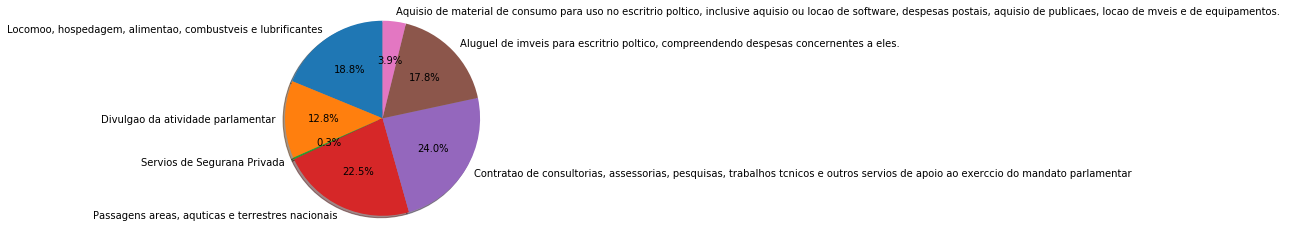

In [19]:
fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

ax1.axis('equal')

plt.show()

### Senadores que mais gastaram no período analisado

In [22]:
df_senador_despesa = df.groupBy('senador').agg(sum(col('valor_reembolsado')).alias('valor_por_senador')).orderBy(desc('valor_por_senador')).select('senador', 'valor_por_senador').limit(10).toPandas()
df_senador_despesa.head(10)

,senador,valor_por_senador
0,PAULO ROCHA,1.950476e+06
1,TELMRIO MOTA,1.899837e+06
2,EDUARDO BRAGA,1.892926e+06
3,SRGIO PETECO,1.778155e+06
4,OMAR AZIZ,1.768824e+06
5,ROBERTO ROCHA,1.748980e+06
6,WELLINGTON FAGUNDES,1.721347e+06
7,FERNANDO COLLOR,1.613320e+06
8,CIRO NOGUEIRA,1.596974e+06
9,ROGRIO CARVALHO,1.592544e+06


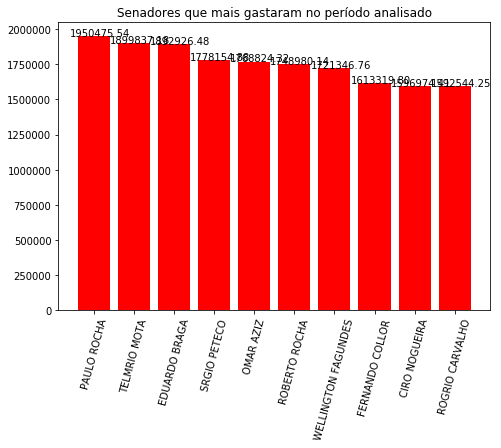

In [23]:
import numpy as np

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
senadores = df_senador_despesa['senador']
valor = df_senador_despesa['valor_por_senador']

ax.bar(senadores,valor, color='red')

plt.xticks(rotation=75)

xlocs=[i+1 for i in range(0,10)]

plt.title('Senadores que mais gastaram no período analisado')

for i, v in enumerate(valor):
    plt.text(xlocs[i] - 1.6, v - 0.25, str('%.2f' % v))

plt.show()

## Gastos por Ano

In [24]:
df_ano_despesa = df.groupBy('ano').agg(sum(col('valor_reembolsado')).alias('valor_por_ano')).select('ano', 'valor_por_ano').toPandas()
df_ano_despesa.head()

,ano,valor_por_ano
0,2018,2.559512e+07
1,2022,5.991514e+06
2,2019,2.523278e+07
3,2020,2.041492e+07
4,2021,2.501068e+07


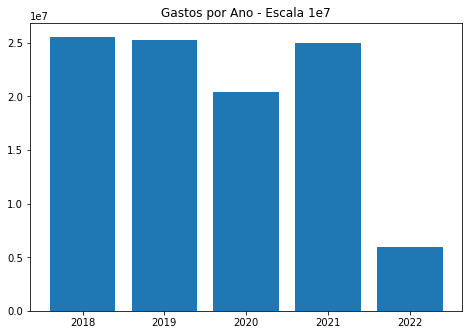

In [25]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ano = df_ano_despesa['ano']
valor = df_ano_despesa['valor_por_ano']

ax.bar(ano, valor)

plt.title('Gastos por Ano - Escala 1e7')

plt.show()

## Gráficos de gastos por meses divididos por anos

In [26]:
df_meses_ano_despesa = df.groupBy('ano','mes').agg(sum(col('valor_reembolsado')).alias('valor_por_ano')).select('ano','mes','valor_por_ano').toPandas()

df_meses_ano_despesa = df_meses_ano_despesa.sort_values(['ano', 'mes'])
df_meses_ano_despesa = df_meses_ano_despesa.reset_index()

# Remover o ano de 2022 pois está incompleto

df_meses_ano_despesa = df_meses_ano_despesa[df_meses_ano_despesa['ano'] != 2022]

df_meses_ano_despesa.groupby('ano').count()

,index,mes,valor_por_ano
ano,,,
2018,12,12,12
2019,12,12,12
2020,12,12,12
2021,12,12,12


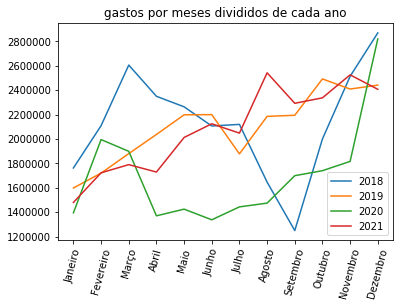

In [27]:
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
        'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

a_2018 = df_meses_ano_despesa[df_meses_ano_despesa['ano'] == 2018]['valor_por_ano']
a_2019 = df_meses_ano_despesa[df_meses_ano_despesa['ano'] == 2019]['valor_por_ano']
a_2020 = df_meses_ano_despesa[df_meses_ano_despesa['ano'] == 2020]['valor_por_ano']
a_2021 = df_meses_ano_despesa[df_meses_ano_despesa['ano'] == 2021]['valor_por_ano']


plt.plot(meses, a_2018, label='2018')
plt.plot(meses, a_2019, label='2019')
plt.plot(meses, a_2020, label='2020')
plt.plot(meses, a_2021, label='2021')

plt.legend(loc='best')

plt.title('gastos por meses divididos de cada ano')

plt.xticks(rotation=75)

plt.show()

## Distribuição de gastos por valor

In [30]:
import pandas as pd
import numpy as np

df_valores = df.select('valor_reembolsado').toPandas()

ranges_list = [0, 100, 1000, 10000, 25000, 50000, 75000, 100000, 1200000]

range_ = pd.cut(df_valores['valor_reembolsado'], [0, 100, 1000, 10000, 25000, 50000, 75000, 100000, 1200000])
counts = pd.value_counts(range_, sort=False)

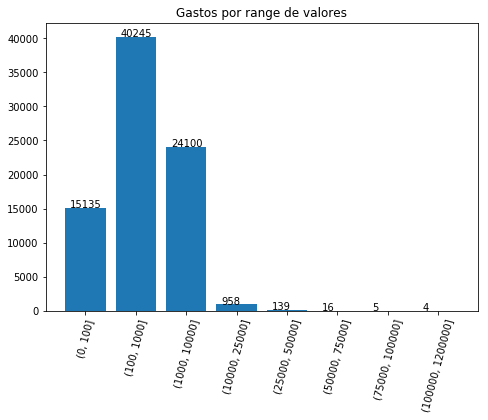

In [29]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.bar(counts.index.astype(str), counts.to_numpy())

xlocs=[i+1 for i in range(0,10)]

for i, v in enumerate(counts.to_numpy()):
    plt.text(xlocs[i] - 1.3, v + 1, str(v))


plt.title('Gastos por range de valores')

plt.xticks(rotation=75)

plt.show()